In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

df = pd.read_csv("/Users/bsama/Downloads/beckdel_allinfo_final.csv")

In [2]:
df1 = df.drop(['imdbid','id','imdb_tt','description'],axis='columns')

In [3]:
df2 = df1.dropna()
df2.isnull().sum()

year            0
rating          0
title           0
genre           0
imdb_rating     0
bechdel_pass    0
dtype: int64

In [4]:
df2.head()

,year,rating,title,genre,imdb_rating,bechdel_pass
0,1874,0,Passage de Venus,"Documentary, Short, History",6.8,No
1,1877,0,La Rosace Magique,"Animation, Short",5.7,No
2,1878,0,Sallie Gardner at a Gallop,"Documentary, Short, Sport",7.3,No
3,1878,0,Le singe musicien,"Animation, Short",6.0,No
4,1881,0,Athlete Swinging a Pick,"Documentary, Short",5.1,No


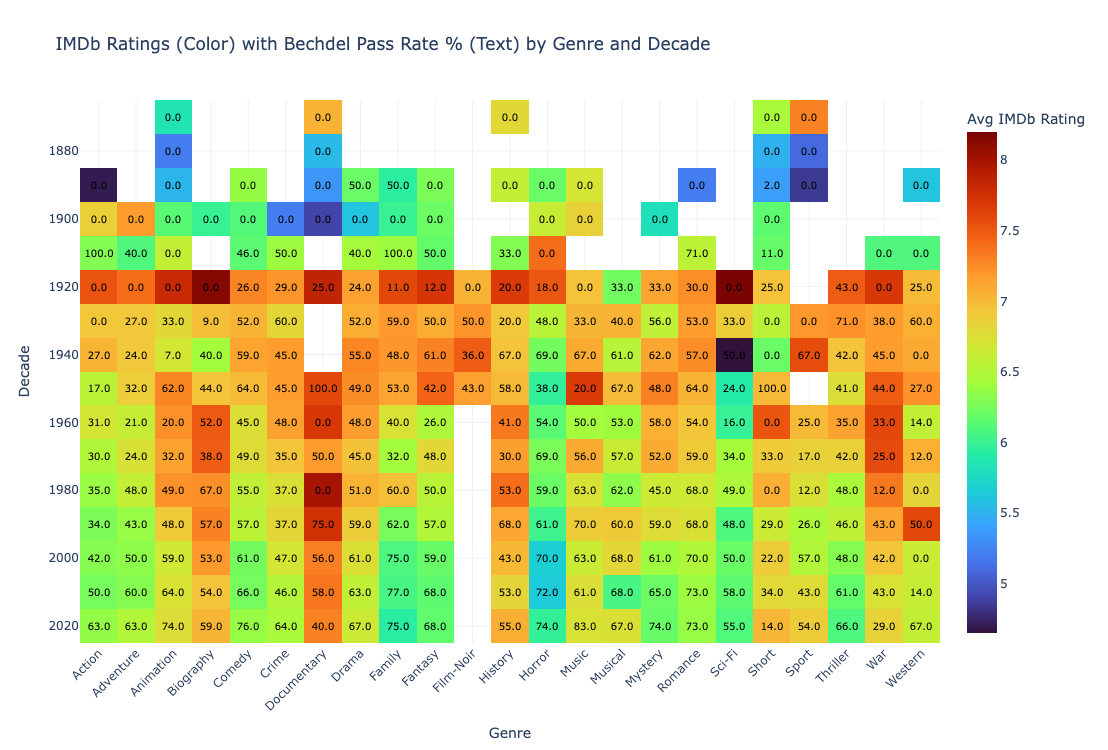

In [5]:
# prepping data
df = df2.copy()

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["imdb_rating"] = pd.to_numeric(df["imdb_rating"], errors="coerce")

# Split multi-genre entries
df["genre"] = df["genre"].str.split(", ")
df = df.explode("genre")

# grouping movies by decade
df["decade"] = (df["year"] // 10) * 10

# filter out small genres
MIN_MOVIES = 50
valid_genres = df["genre"].value_counts()
valid_genres = valid_genres[valid_genres >= MIN_MOVIES].index
df = df[df["genre"].isin(valid_genres)]

# aggregate metrics
summary = (
    df.groupby(["decade", "genre"])
      .agg(
          avg_rating=("imdb_rating", "mean"),
          pass_rate=("bechdel_pass", lambda x: (x == "Yes").mean() * 100),
          count=("title", "count")
      )
      .reset_index()
)

# pivot for heatmap
rating_pivot = summary.pivot(
    index="decade",
    columns="genre",
    values="avg_rating"
)

pass_text = summary.pivot(
    index="decade",
    columns="genre",
    values="pass_rate"
).round(0)

# clean nan values in heatmap
Z_clean = rating_pivot.copy().astype(float)
Z_clean[np.isnan(Z_clean)] = None

T_clean = pass_text.copy()
T_clean = np.where(np.isnan(T_clean), "", T_clean)

# build heatmap
fig = px.imshow(
    Z_clean,
    aspect="auto",
    color_continuous_scale="Turbo",
    labels=dict(
        x="Genre",
        y="Decade",
        color="Avg IMDb Rating"
    ),
    title="IMDb Ratings (Color) with Bechdel Pass Rate % (Text) by Genre and Decade"
)

# Add Bechdel % text
fig.update_traces(
    text=T_clean.astype(str) + "",
    texttemplate="%{text}",
    textfont=dict(color="black", size=10)
)

# styling
fig.update_layout(
    template="plotly_white",
    height=750,
    xaxis_tickangle=-45
)

fig.show()